In [72]:
# from sklearn
import pandas as pd
import seaborn as sns; sns.set()
import pickle
import matplotlib as plt
%matplotlib inline

In [73]:
token_data=pd.read_csv("../data/wowcointotal.csv")

In [74]:
token_data.head()

,Region,Date,Price,Time left on Auction
0,US,4/7/2015 17:12,30000,Short
1,US,4/7/2015 17:42,30000,Short
2,US,4/7/2015 18:13,30300,Short
3,US,4/7/2015 18:42,30300,Short
4,US,4/7/2015 19:04,30603,Short


In [75]:
token_data.shape

(115274, 4)

In [76]:
token_data.rename(columns=lambda x: x.replace(" ","_"), inplace=True)
token_data.rename(columns=lambda x: x.lower(), inplace=True)

## Previous trial
# splitted_date= [str(token_data["Date"][i]).split(" ") for i in range(len(token_data["Date"]))]
# days=[splitted_date[i][0] for i in range(len(splitted_date))]
# hour=[splitted_date[i][1] for i in range(len(splitted_date))]
# hour=[hour[i][:-2]+ "00" for i in range(len(hour))]
# token_data["day"] = days
# token_data["hour"] = hour

# This one line does what I've tried to achieve above
token_data['date_time'] =  pd.to_datetime(token_data['date'])
token_data['date_time'] =  token_data["date_time"].dt.strftime('%Y-%m-%d')

token_data.drop("date",axis=1,errors="ignore",inplace=True)

token_data.head()

,region,price,time_left_on_auction,date_time
0,US,30000,Short,2015-04-07
1,US,30000,Short,2015-04-07
2,US,30300,Short,2015-04-07
3,US,30300,Short,2015-04-07
4,US,30603,Short,2015-04-07


In [77]:
token_data.dtypes

region                  object
price                    int64
time_left_on_auction    object
date_time               object
dtype: object

In [78]:
token_data.dtypes

region                  object
price                    int64
time_left_on_auction    object
date_time               object
dtype: object

In [79]:
print(token_data.region.value_counts())
print("\n")
print(token_data.time_left_on_auction.value_counts())

US    115274
Name: region, dtype: int64


Long         109679
Short           495
Medium          327
Very Long       226
Name: time_left_on_auction, dtype: int64


In [80]:
sub_US = token_data[token_data["region"]=="US"]

In [81]:
sub_US.shape

(115274, 4)

In [82]:
sub_US.drop(labels="region",axis=1,inplace=True)

In [83]:
sub_US.head()

,price,time_left_on_auction,date_time
0,30000,Short,2015-04-07
1,30000,Short,2015-04-07
2,30300,Short,2015-04-07
3,30300,Short,2015-04-07
4,30603,Short,2015-04-07


In [84]:
sub_US_long = sub_US[sub_US["time_left_on_auction"]=="Long"]
sub_US_short = sub_US[sub_US["time_left_on_auction"]=="Short"]
sub_US_meedium = sub_US[sub_US["time_left_on_auction"]=="Medium"]
sub_US_very_long = sub_US[sub_US["time_left_on_auction"]=="Very Long"]

In [85]:
sub_US_long.shape

(109679, 3)

In [90]:
sub_US_long_model = sub_US_long.copy()
sub_US_long_model.drop("time_left_on_auction",axis=1,inplace=True,errors="ignore")
sub_US_long_model.head()

,price,date_time
71,21959,2015-04-08
72,21959,2015-04-08
73,21959,2015-04-08
74,21739,2015-04-08
75,21739,2015-04-08


In [98]:
sub_US_long_model = sub_US_long_model.groupby("date_time").mean()
sub_US_long_model.head()

,price
date_time,
2015-04-08,21468.000000
2015-04-09,20675.000000
2015-04-10,25383.244444
2015-04-11,22754.000000
2015-04-12,21985.716981


In [99]:
sns.set(rc={'figure.figsize':(14,8)})

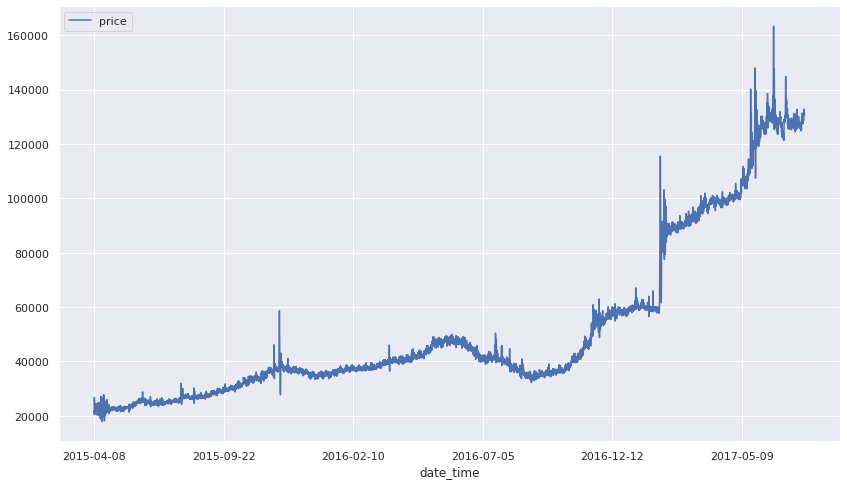

In [100]:
sub_US_long.plot(x="date_time",y="price")

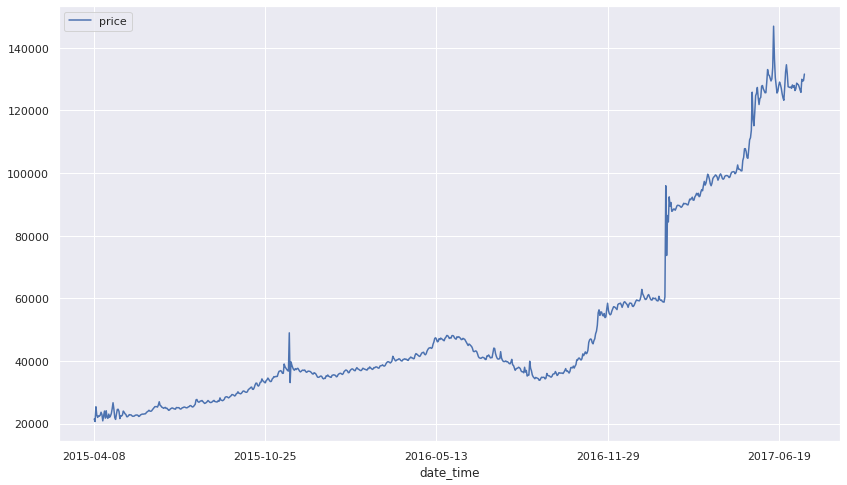

In [102]:
sub_US_long_model.plot(y="price")

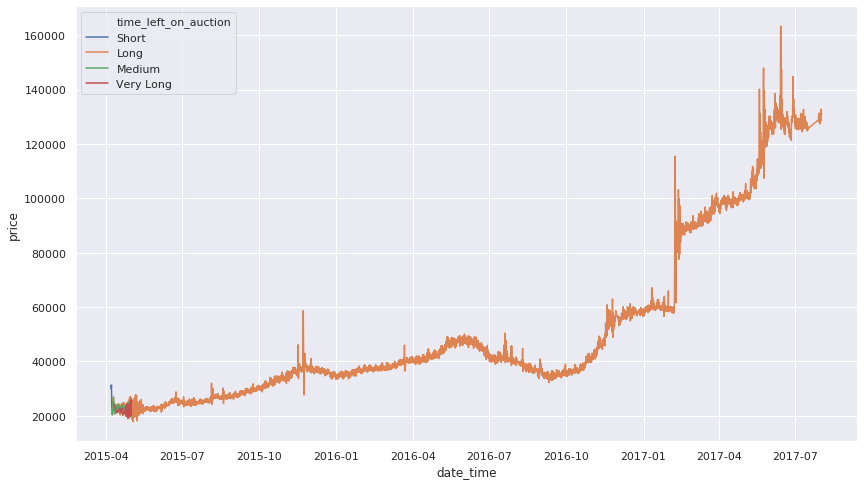

In [46]:
sns.lineplot(x="date_time", y="price", hue="time_left_on_auction", data=sub_US)

In [103]:
sub_US_long_model.dtypes

price    float64
dtype: object

In [104]:
from statsmodels.tsa.arima_model import ARIMA

In [105]:
model = ARIMA(sub_US_long_model,order=(5,1,0))
model_fit= model.fit(disp=0)
print(model_fit.summary())

/home/vajk/projects/deploy_ml_tst/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/vajk/projects/deploy_ml_tst/env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  830
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7455.047
Method:                       css-mle   S.D. of innovations           1925.449
Date:                Sun, 01 Mar 2020   AIC                          14924.093
Time:                        14:43:15   BIC                          14957.143
Sample:                             1   HQIC                         14936.768
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           131.5603     38.563      3.412      0.001      55.978     207.142
ar.L1.D.price    -0.3949      0.035    -11.394      0.000      -0.463      -0.327
ar.L2.D.price    -0.0799      0.037     

In [112]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [170]:
X=sub_US_long_model.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=36111.172182, expected=36011.548611
predicted=36194.510535, expected=36449.986111
predicted=36295.018407, expected=36957.842857
predicted=36587.703705, expected=37572.251908
predicted=36971.114970, expected=36780.513889
predicted=36868.757073, expected=36860.083333
predicted=36694.384450, expected=36542.263889
predicted=36732.595783, expected=36155.444444
predicted=36715.513035, expected=36701.659722
predicted=36800.015508, expected=37889.590278
predicted=37214.333932, expected=37939.765957
predicted=37599.053557, expected=37810.645833
predicted=37466.979190, expected=38359.333333
predicted=37577.703382, expected=37755.972222
predicted=37807.721501, expected=38380.377622
predicted=38122.973471, expected=38830.465278
predicted=38432.935107, expected=40377.854167
predicted=39194.432904, expected=40341.102564
predicted=39700.202129, expected=40886.500000
predicted=39871.810268, expected=40942.205674
predicted=40215.468698, expected=40572.902778
predicted=40408.106577, expected=4

predicted=99399.402162, expected=99240.861111
predicted=99513.566006, expected=98750.859155
predicted=99179.141984, expected=97741.263889
predicted=98466.496720, expected=98426.312500
predicted=98289.004716, expected=99292.435714
predicted=98972.815039, expected=99757.538462
predicted=99577.310554, expected=99255.402778
predicted=99652.861004, expected=98359.625000
predicted=99039.606771, expected=98040.676056
predicted=98445.585123, expected=98249.354545
predicted=98317.628007, expected=98984.729167
predicted=98720.232421, expected=99162.561151
predicted=99167.803198, expected=99221.122302
predicted=99332.874884, expected=99191.180556
predicted=99395.158087, expected=98977.791667
predicted=99263.519578, expected=98572.812500
predicted=98952.683325, expected=98774.063380
predicted=98852.459201, expected=99670.985714
predicted=99363.481615, expected=100282.769784
predicted=100066.379692, expected=100370.375000
predicted=100443.028021, expected=100468.200000
predicted=100603.522061, expe

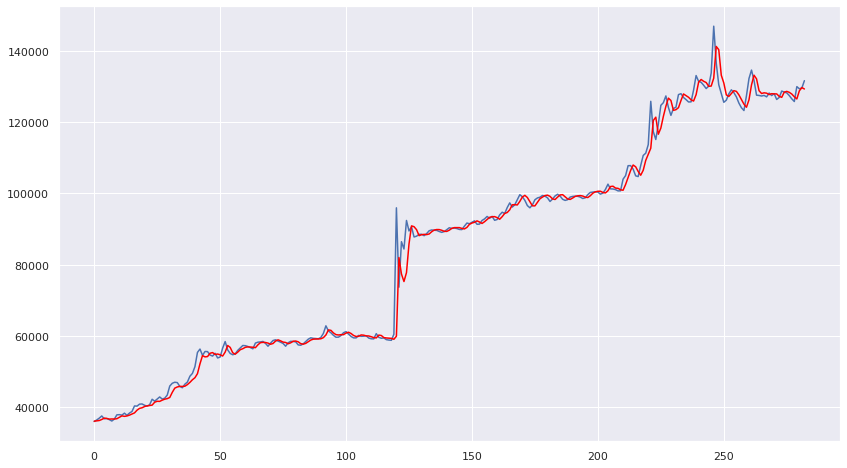

In [113]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [114]:
sub_US_long_model.tail()

,price
date_time,
2017-07-15,125786.535714
2017-07-28,129965.032258
2017-07-29,129350.322581
2017-07-30,129576.041667
2017-07-31,131625.388489


In [173]:
# # start_index = pd.datetime(2017, 7,15 ).date()
# # end_index = pd.datetime(2017,7,19).date()

# start_index = pd.to_datetime("2017-07-15").strftime('%Y-%m-%d')
# end_index = pd.to_datetime("2017-07-20").strftime('%Y-%m-%d')
# end_index
forecast = model_fit.forecast(steps=8)

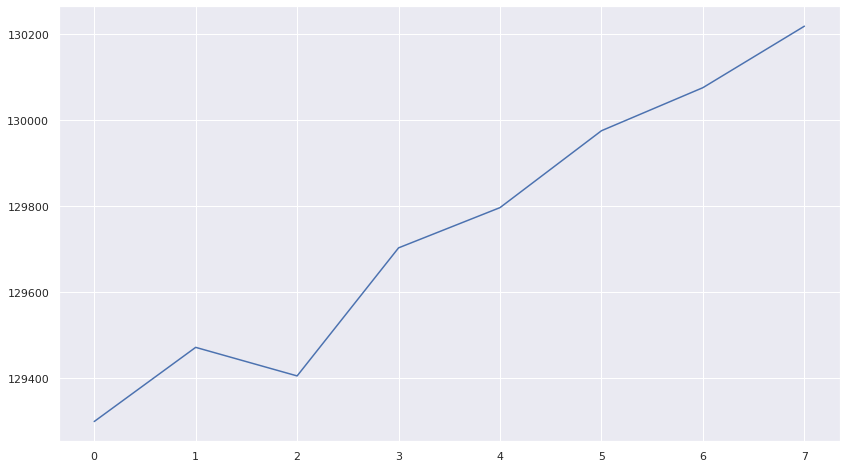

In [174]:
pyplot.plot(forecast[0])

In [162]:
filename = 'token_predictor_model.pkl'
pickle.dump(model_fit, open(filename, 'wb'))